In [1]:
import pandas as pd
import numpy as np
import math
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import mquantiles
from plotnine import *

import pymc3 as pm
import warnings
warnings.filterwarnings('ignore')
import theano
import theano.tensor as tt
import arviz as az

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


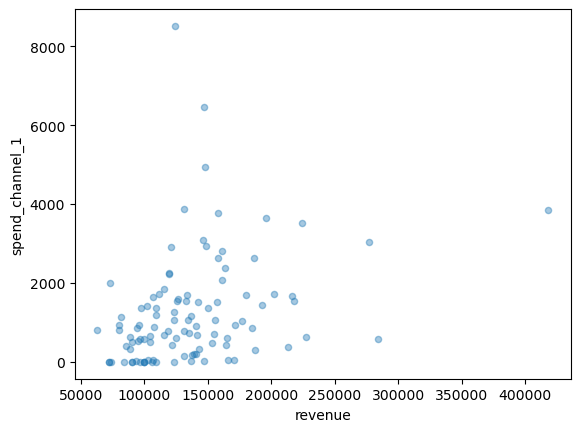

In [2]:
data = pd.read_csv(
  'https://raw.githubusercontent.com/haensel-ams/recruitment_challenge/master/DataScience_202209/MMM_test_data.csv',
  parse_dates=['start_of_week'],
  index_col='start_of_week'
)

data.plot.scatter("revenue", "spend_channel_1", alpha=0.4);

In [6]:
with pm.Model() as model_spend1:
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)
    γ = pm.HalfNormal("γ", sigma=10)
    δ = pm.HalfNormal("δ", sigma=10)

    spend1 = pm.Data("spen_channel_1", data.spend_channel_1.values.astype(float)+10)

    μ = pm.Deterministic("μ", α + β * spend1 ** 0.5)
    ε = pm.Deterministic("ε", γ + δ * spend1)

    revenue = pm.Normal("revenue", mu=μ, sigma=ε, observed=data.revenue)

    trace_spend1 = pm.sample(tune=500, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [δ, γ, β, α]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 150 seconds.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
The acceptance probability does not match the target. It is 0.9790238784776636, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9676255725241472, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9982204500608051, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.976287599165868, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or r

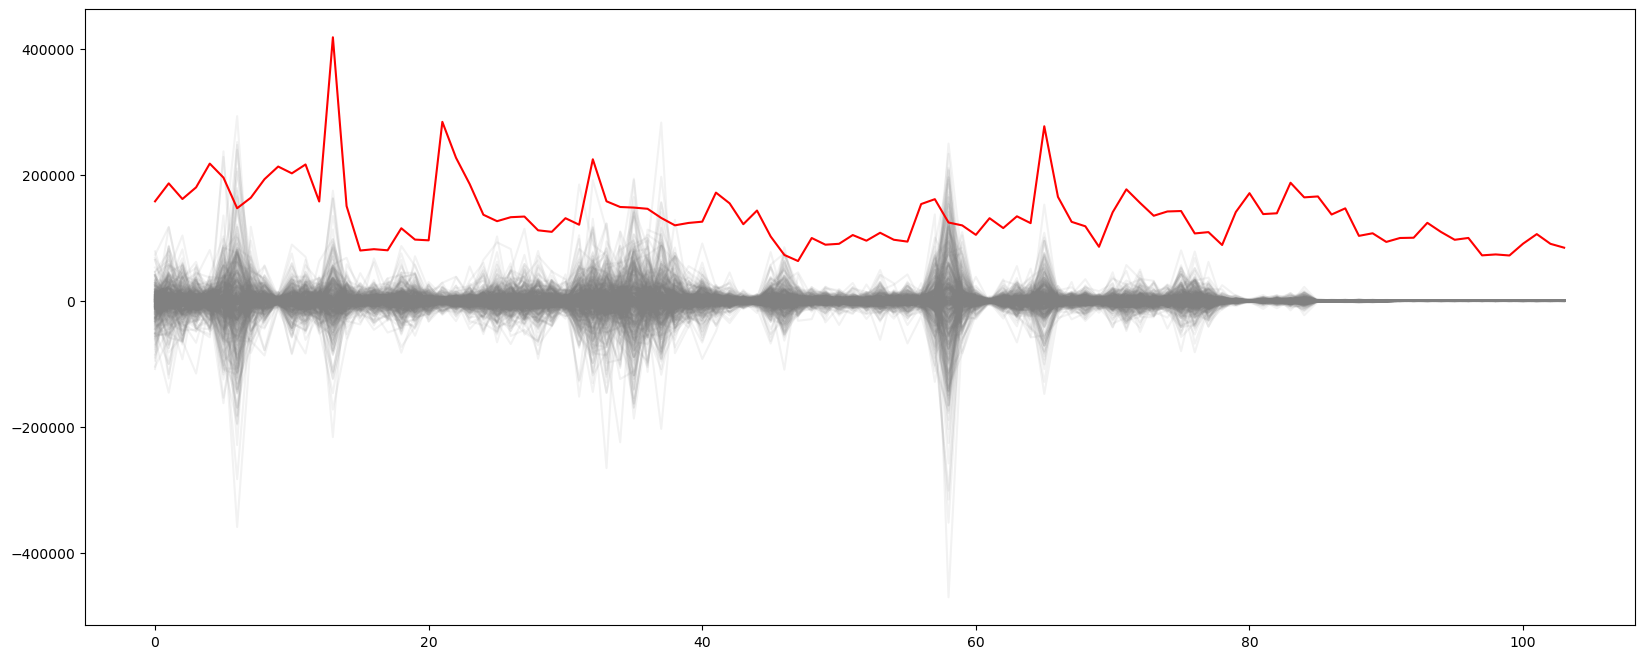

In [8]:
with model_spend1:
    prior_pred = pm.sample_prior_predictive()
    
fig, ax = plt.subplots(figsize = (20, 8))
_ = ax.plot(prior_pred["revenue"].T, color = "0.5", alpha = 0.1)
_ = ax.plot(data['revenue'].values, color = "red")

In [10]:
with model_spend1:
    pp_spend1 = pm.sample_posterior_predictive(trace_spend1)["revenue"]

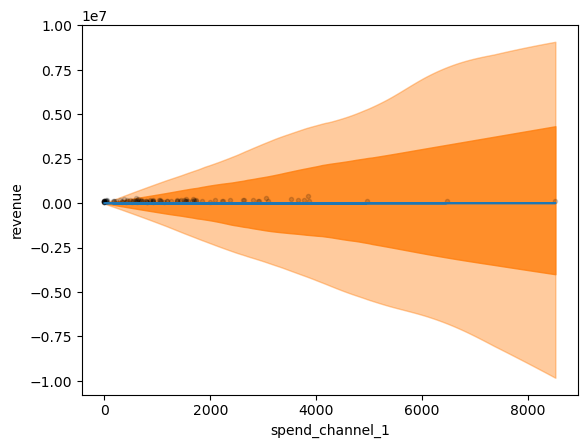

In [12]:
fig, ax = plt.subplots()

ax.plot(data.spend_channel_1, data.revenue, "k.", alpha=0.15)
ax.plot(data.spend_channel_1, trace_spend1["μ"].mean(0))

az.plot_hdi(data.spend_channel_1, pp_spend1, hdi_prob=0.6, fill_kwargs={"alpha": 0.8})
az.plot_hdi(data.spend_channel_1, pp_spend1, fill_kwargs={"alpha": 0.4})

plt.xlabel("spend_channel_1")
plt.ylabel("revenue");

In [14]:
with model_spend1:
    display(az.summary(trace_spend1, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.64,7.59,-12.41,20.03,0.91,1.22,45.15,198.07,1.99
β,6.07,9.23,-2.43,27.87,3.10,2.27,8.65,122.02,2.02
γ,46.69,20.94,8.97,72.82,9.53,7.20,6.75,11.32,1.59
δ,585.38,5.31,575.52,595.18,0.74,0.53,51.21,1216.67,1.05
μ[0],313.28,475.16,-121.12,1435.02,160.08,117.17,8.65,120.96,2.03
...,...,...,...,...,...,...,...,...,...
ε[99],5900.51,50.39,5806.50,5993.04,0.79,0.56,4038.64,2763.78,1.00
ε[100],5900.51,50.39,5806.50,5993.04,0.79,0.56,4038.64,2763.78,1.00
ε[101],5900.51,50.39,5806.50,5993.04,0.79,0.56,4038.64,2763.78,1.00
ε[102],5900.51,50.39,5806.50,5993.04,0.79,0.56,4038.64,2763.78,1.00


In [15]:
pp_spend1

array([[ 1.27818496e+06, -5.44196298e+05,  2.20789083e+05, ...,
        -1.61373911e+03, -5.71955790e+03, -5.35391603e+03],
       [ 1.57731054e+06,  1.06780450e+05,  1.47751325e+06, ...,
        -3.96960462e+03,  1.07817393e+03, -6.17952166e+02],
       [-2.71301037e+06,  1.07336311e+06, -3.32453840e+05, ...,
         2.23471773e+03,  4.88581871e+03,  1.63939857e+03],
       ...,
       [ 1.97525873e+06, -1.32131870e+05, -1.65537794e+06, ...,
        -2.66998492e+03,  3.45565553e+03,  2.74606180e+03],
       [ 2.88128403e+06, -8.95205397e+05,  1.33622512e+05, ...,
         1.32822306e+03,  7.24824911e+03, -5.82071802e+03],
       [ 5.92076554e+05,  5.31840219e+05, -6.20274045e+05, ...,
        -3.02422130e+03,  4.94929668e+03,  1.11581459e+04]])

In [16]:
model_spend1